In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
from ripser import Rips
import matplotlib.pyplot as plt
from persim import plot_diagrams
from matplotlib import rcParams, rcParamsDefault

# Plotting of Molecule and Transition

In [2]:
def get_molecule(path: str):
    type_map_path = os.path.join(path, 'type_map.raw')
    type_path = os.path.join(path, 'type.raw')
    with open(type_map_path, 'r', encoding = 'utf-8') as map_file:
        file_dat = map_file.read()
        type_maps = dict(enumerate(file_dat.strip('\n').split('\n')))

    with open(type_path, 'r', encoding='utf-8') as type_file:
        lines = list(map(int, type_file.read().strip('\n').split('\n')))
    
    convert = list(map(lambda x: type_maps[x], lines))
    convert_counts = defaultdict(int)
    for con in convert:
        convert_counts[con] += 1
    return convert_counts, convert, type_maps

def get_diagrams(path: str, num_trans:int = 5):
    rips = Rips(maxdim=2, thresh=10, verbose = 0)
    coords_path = os.path.join(path, 'coord.raw')
    total_lines = []
    with open(coords_path, 'r', encoding='utf-8') as coords_file:
        lines = coords_file.readlines()
        len_of_file = len(lines)
        total_lines = [list(map(float, line.split(' '))) for line in lines]
        total_array = np.array(total_lines).reshape((len_of_file, -1, 3))
        subset_array = total_array[:num_trans, ...]

    diagrams = {i: rips.fit_transform(subset_array[i]) for i in range(num_trans)}
    return subset_array, diagrams

def get_atom_color(atom:str):
    jmol = pd.read_csv("./jmol_colors.csv")
    r = jmol[jmol['atom'] == atom]['R'].values[0] / 255.0
    g = jmol[jmol['atom'] == atom]['G'].values[0] / 255.0
    b = jmol[jmol['atom'] == atom]['B'].values[0] / 255.0
    return (r, g, b)

def plot_pers_diagrams(path: str, num_trans: int = 5):
    rcParams.update(rcParamsDefault)
    coords, diagrams = get_diagrams(path=path, num_trans=num_trans)
    fig, axs = plt.subplots(2, num_trans)
    convert_counts, convert, type_map = get_molecule(path)
    type_frame = pd.DataFrame(convert, columns = ['Atom'])
    type_frame['colors'] = type_frame['Atom'].apply(lambda x: get_atom_color(x))
    unq_atoms = type_frame['Atom'].unique()
    for i, (k, v) in enumerate(diagrams.items()):
        axs[1, i].remove()
        axs[1, i] = fig.add_subplot(2, num_trans, num_trans + i + 1, projection='3d')
        coords_frame = pd.DataFrame(coords[i, ...].tolist(), columns = ['x', 'y', 'z'])
        new_frame = pd.concat([type_frame, coords_frame], axis = 1)
        for u in unq_atoms:
            subset = new_frame[new_frame['Atom'] == u]
            axs[1, i].scatter(subset['x'], subset['y'], subset['z'], c = subset['colors'], label = u)
        if i == 0:
            axs[1, i].legend()
        axs[1, i].set_xlabel("x")
        axs[1, i].set_ylabel('y')
        axs[1, i].set_zlabel('z')
        axs[1, i].zaxis._axinfo['juggled'] = (1, 2, 2)

        # Plot pers diag
        plot_diagrams(v, ax=axs[0, i])
    plt.suptitle(f"{path=}")
    plt.tight_layout()
    plt.show()


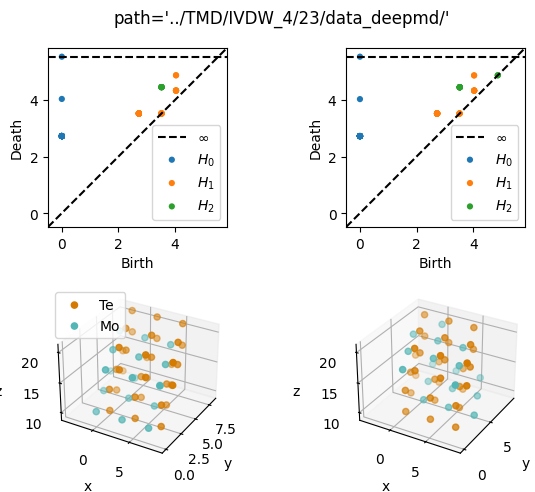

In [3]:
mol_path = "../TMD/IVDW_4/23/data_deepmd/"
plot_pers_diagrams(mol_path, num_trans=2)

# Supercell Creation

In [17]:
import pymatgen.core as pmg
from pymatgen.vis.structure_chemview import quick_view
from gudhi.representations import Landscape

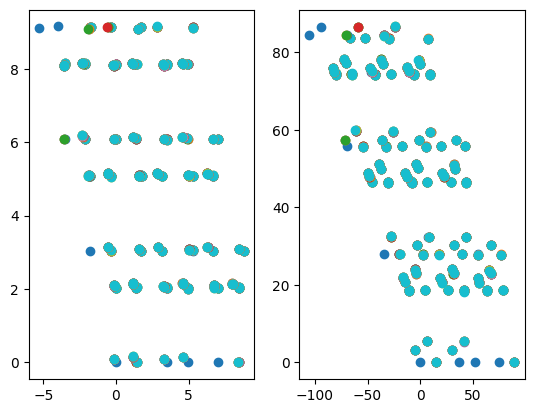

In [11]:
convert_counts, convert, _ = get_molecule(mol_path)
mol_string = "".join([k+str(v) for k, v in convert_counts.items()])

coord_path = os.path.join(mol_path, 'coord.raw')
box_path = os.path.join(mol_path, 'box.raw')
num_trans = 20
with open(coord_path, 'r', encoding = 'utf-8') as coord:
    first_coord = coord.read().split('\n')[:num_trans]
    first_coord = [fc.split(" ") for fc in first_coord]
    first_coord = np.array(first_coord).astype(float).reshape((num_trans, -1, 3))

with open(box_path, 'r', encoding='utf-8') as box:
    first_box = box.read().split('\n')[:num_trans]
    first_box = [fb.split(" ") for fb in first_box]
    first_box = np.array(first_box).astype(float).reshape((num_trans, 3, 3))


fig, ax = plt.subplots(1, 2)
for i in range(num_trans):
    reverse_box = first_box[i, ...]
    final = first_coord[i, ...] @ reverse_box
    ax[0].scatter(first_coord[i, :, 0], first_coord[i, :, 1], label = i)
    ax[1].scatter(final[:, 0], final[:, 1], label = i)
ax[0].title.set_text("")
plt.show()

In [73]:
def create_supercell(sc_size: int):
    lattice = pmg.Lattice(first_box[0, ...])
    struct = pmg.Structure(lattice, convert, first_coord[0, ...])
    struct.make_supercell([sc_size, sc_size, 1])
    coords = struct.cart_coords.reshape((sc_size, sc_size, -1, 3))
    return {'coords': coords, 'struct': struct}

def get_peaks(coords, num_landscape:int = 5, resolution:int = 100):
    num_rows = coords.shape[0]
    landscape = Landscape(num_landscapes=num_landscape, resolution=resolution)
    rips = Rips(maxdim=2, verbose=0)
    data = []
    for i in range(num_rows):
        for j in range(num_rows):
            cell = coords[i, j, ...]
            curr_rips = rips.fit_transform(cell)
            if len(curr_rips[2]) > 0:
                curr_land = landscape.fit_transform([curr_rips[2]])
                peak_idx = np.argmax(curr_land)
                peak_value = curr_land.max()
            else:
                peak_idx, peak_value = 0, 0
            curr_data = [i, j, peak_idx, peak_value]
            data.append(curr_data)
    peaks_data = pd.DataFrame(data, columns = ['RowIndex', 'ColIndex', 'PeakIndex', 'PeakValue'])
    return peaks_data

def collect_data(sizes: list[int]):
    frames = []
    for size in sizes:
        cell_data = create_supercell(size)
        peaks_frame = get_peaks(cell_data['coords'])
        peaks_frame['SupercellSize'] = size
        frames.append(peaks_frame)
    total_peaks_frames = pd.concat(frames, axis = 0, ignore_index=True)
    return total_peaks_frames

def plot_supercell_frames(supercell_frames: pd.DataFrame):

    unq_sizes = supercell_frames['SupercellSize'].unique()

    fig, ax = plt.subplots(len(unq_sizes), 1, figsize = (10, 10))
    for i, u in enumerate(unq_sizes):
        subset = supercell_frames[supercell_frames['SupercellSize'] == u]
        init_peaks = np.zeros((u, u))
        for _, frame_row in subset.iterrows():
            mat_row = int(frame_row['RowIndex'])
            mat_col = int(frame_row['ColIndex'])
            peak_value = frame_row['PeakValue']
            init_peaks[mat_row, mat_col] = peak_value
        im = ax[i].matshow(init_peaks, aspect = 'auto')
        ax[i].title.set_text(f"{u}x{u}")
        plt.colorbar(im, ax = ax[i])
        
    plt.suptitle("Peak Landscapes of Varying Supercell Sizes")
    plt.tight_layout()
    plt.show()

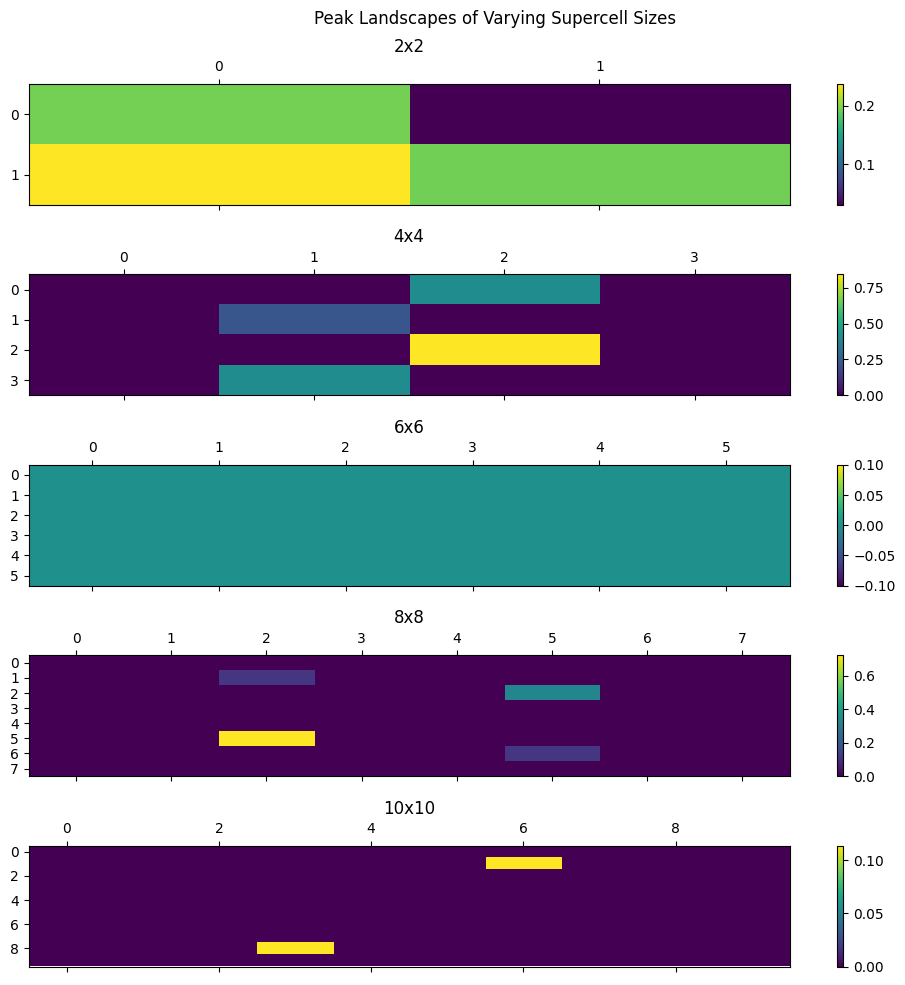

In [78]:
supercell_sizes = [2, 4, 6, 8, 10]
peaks_frame = collect_data(supercell_sizes)
plot_supercell_frames(peaks_frame)

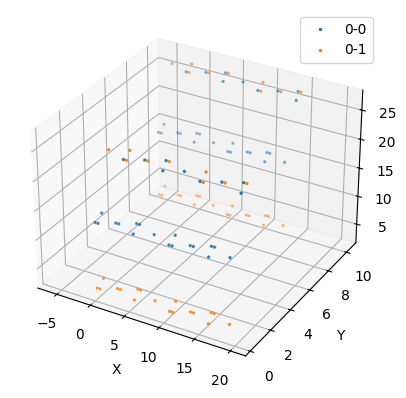

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

sc_size = 2
supercell22 = create_supercell(sc_size)
supercell22_coords = supercell22['coords']
for i in range(sc_size):
    if i == 0:
        for j in range(sc_size):
            temp_data = pd.DataFrame(supercell22_coords[i, j], columns = ['X', 'Y', 'Z'])
            temp_data = temp_data.sort_values(by = ['X', 'Z', 'Y'])
            ax.scatter(temp_data['X'], temp_data['Y'], temp_data['Z'], label = f"{i}-{j}", s = 2)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

In [94]:
temp_data

,X,Y,Z
3,-5.791210,10.030669,9.0060
9,-4.857600,9.145228,9.0060
36,-3.761525,9.587949,20.9946
12,-2.578805,9.587949,9.0060
41,-1.482730,10.030669,20.9946
21,-0.971520,9.145228,20.9946
43,-0.549120,9.145228,20.9946
17,-0.300010,10.030669,9.0060
8,0.422400,0.000000,9.0060
24,1.307275,9.587949,20.9946
